Rows after cleaning: 95491
Unique FSAs: 51


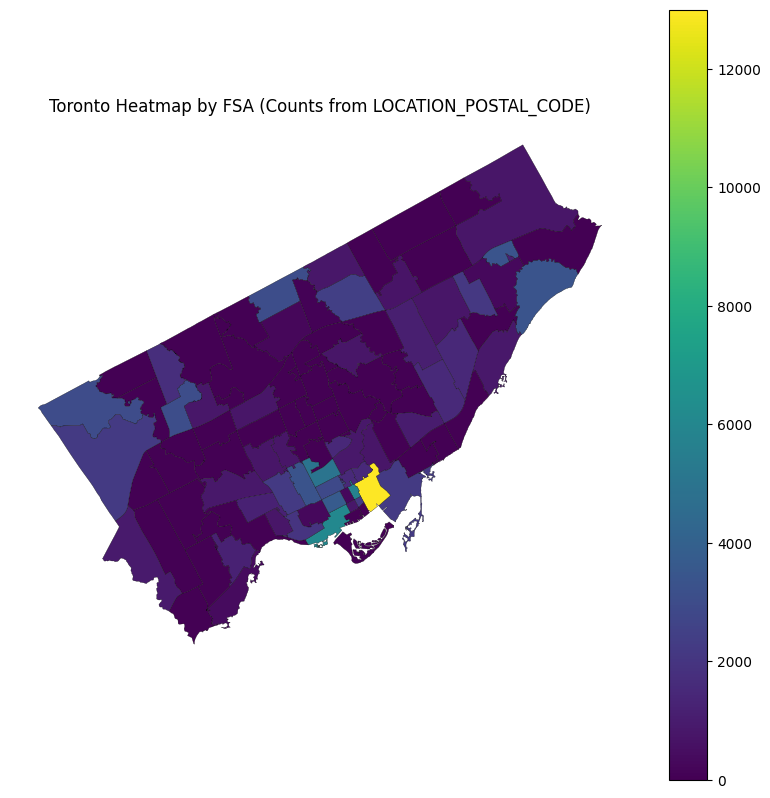

In [1]:
# This is the original heatmap one
# =========================
# TORONTO GEO HEATMAP (NO files.upload)
# Assumes the files already exist in Colab's file panel:
#   - /content/public_services.csv
#   - /content/canada_fsa.geojson
# =========================

!pip -q install geopandas shapely pyproj fiona folium

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import os

CSV_FILE = "/content/public_services.csv"
GEO_FILE = "/content/lfsa000b16a_e.shp"

# (optional) quick check that files exist
assert os.path.exists(CSV_FILE), f"Missing: {CSV_FILE}"
assert os.path.exists(GEO_FILE), f"Missing: {GEO_FILE}"

# -------------------------
# 1) Load + clean postal codes
# -------------------------
POST_COL = "LOCATION_POSTAL_CODE"

df = pd.read_csv(
    CSV_FILE,
    usecols=[POST_COL],
    dtype={POST_COL: "string"}
)

# Drop real missing values (prevents 'NAN' strings)
df = df.dropna(subset=[POST_COL]).copy()

# Clean: uppercase + remove spaces
df[POST_COL] = df[POST_COL].str.upper().str.replace(" ", "", regex=False)

# Keep only valid Canadian postal codes in A1A1A1 format
pattern = r"[ABCEGHJ-NPRSTVXY]\d[ABCEGHJ-NPRSTV-Z]\d[ABCEGHJ-NPRSTV-Z]\d"
df = df[df[POST_COL].str.fullmatch(pattern, na=False)].copy()

# Extract FSA
df["FSA"] = df[POST_COL].str[:3]

print("Rows after cleaning:", len(df))
print("Unique FSAs:", df["FSA"].nunique())

# -------------------------
# 2) Aggregate counts per FSA
# -------------------------
heat = df.groupby("FSA").size().reset_index(name="count")

# -------------------------
# 3) Load boundaries + filter Toronto
# -------------------------
gdf = gpd.read_file(GEO_FILE)

# Most common FSA id column in StatsCan boundary files:
FSA_COL = "CFSAUID"
if FSA_COL not in gdf.columns:
    raise ValueError(f"'{FSA_COL}' not found in boundary file. Available columns: {list(gdf.columns)}")

toronto_fsa = gdf[gdf[FSA_COL].astype(str).str.startswith("M")][[FSA_COL, "geometry"]].copy()

# Simplify geometry for speed (increase tolerance if still slow)
toronto_fsa["geometry"] = toronto_fsa["geometry"].simplify(tolerance=0.001, preserve_topology=True)

# -------------------------
# 4) Merge
# -------------------------
map_df = toronto_fsa.merge(heat, left_on=FSA_COL, right_on="FSA", how="left")
map_df["count"] = map_df["count"].fillna(0)

# -------------------------
# 5) FAST: static choropleth
# -------------------------
fig, ax = plt.subplots(figsize=(10, 10))
map_df.plot(column="count", legend=True, linewidth=0.2, edgecolor="black", ax=ax)
ax.set_title("Toronto Heatmap by FSA (Counts from LOCATION_POSTAL_CODE)")
ax.axis("off")
plt.show()

# -------------------------
# 6) OPTIONAL: interactive Folium
# -------------------------
map_df_4326 = map_df.to_crs(epsg=4326)

m = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

folium.Choropleth(
    geo_data=map_df_4326,
    data=map_df_4326,
    columns=[FSA_COL, "count"],
    key_on=f"feature.properties.{FSA_COL}",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Count"
).add_to(m)

m

In [5]:
# =========================
# TORONTO SHELTER OCCUPANCY — WEEKLY ANIMATED MAP (FINAL, FIXED)
# Assumes these exist in Colab:
#   - /content/public_services.csv
#   - /content/lfsa000b16a_e.shp (+ .dbf/.shx/.prj sidecars)
# =========================

# -------------------------
# Imports
# -------------------------
import os
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
from folium import plugins

# -------------------------
# Files
# -------------------------
CSV_FILE = "/content/public_services.csv"
GEO_FILE = "/content/lfsa000b16a_e.shp"

assert os.path.exists(CSV_FILE), f"Missing: {CSV_FILE}"
assert os.path.exists(GEO_FILE), f"Missing: {GEO_FILE}"

# -------------------------
# Column names in your CSV (CONFIRMED)
# -------------------------
POST_COL = "LOCATION_POSTAL_CODE"
DATE_COL = "OCCUPANCY_DATE"      # if yours differs, change here
CAP = "ACTUAL_CAPACITY"
OCC = "OCCUPIED_CAPACITY"

# -------------------------
# 1) Load CSV (FIXED usecols)
# -------------------------
usecols = [POST_COL, DATE_COL, CAP, OCC]
df = pd.read_csv(CSV_FILE, usecols=usecols)

# Clean postal code
df[POST_COL] = df[POST_COL].astype("string")
df = df.dropna(subset=[POST_COL]).copy()
df[POST_COL] = df[POST_COL].str.upper().str.replace(" ", "", regex=False)

pattern = r"[ABCEGHJ-NPRSTVXY]\d[ABCEGHJ-NPRSTV-Z]\d[ABCEGHJ-NPRSTV-Z]\d"
df = df[df[POST_COL].str.fullmatch(pattern, na=False)].copy()
df["FSA"] = df[POST_COL].str[:3]

# Numeric clean
df[CAP] = pd.to_numeric(df[CAP], errors="coerce")
df[OCC] = pd.to_numeric(df[OCC], errors="coerce")
df = df.dropna(subset=[CAP, OCC]).copy()

# Date clean
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.dropna(subset=[DATE_COL]).copy()

# -------------------------
# 2) Load FSA shapefile + get representative points (lat/lon)
# -------------------------
g_fsa = gpd.read_file(GEO_FILE)

# Find an FSA column (StatsCan LFSA usually uses CFSAUID)
candidate_cols = ["CFSAUID", "FSA", "FSAUID"]
fsa_col = next((c for c in candidate_cols if c in g_fsa.columns), None)
if fsa_col is None:
    raise ValueError(
        f"Could not find an FSA code column in shapefile. Available: {list(g_fsa.columns)}"
    )

g_fsa = g_fsa.rename(columns={fsa_col: "FSA"}).copy()
g_fsa["FSA"] = g_fsa["FSA"].astype(str).str.upper().str.strip()

# Ensure WGS84 for folium
if g_fsa.crs is None:
    raise ValueError(
        "Shapefile CRS is missing. Set it with g_fsa.set_crs(...), then g_fsa.to_crs(4326)."
    )
g_fsa = g_fsa.to_crs(epsg=4326)

# Representative points for plotting (stable inside polygon)
g_fsa["pt"] = g_fsa.geometry.representative_point()
g_fsa["lon"] = g_fsa["pt"].x
g_fsa["lat"] = g_fsa["pt"].y
fsa_pts = g_fsa[["FSA", "lat", "lon"]].drop_duplicates()

# Join lat/lon into df
df = df.merge(fsa_pts, on="FSA", how="inner").dropna(subset=["lat", "lon"]).copy()

# -------------------------
# 3) WEEKLY BINNING (true aggregation)
# -------------------------
df["BIN"] = df[DATE_COL].dt.to_period("W").astype(str)
bins_all = sorted(df["BIN"].unique().tolist())

start_period = pd.Period("2024-01-01", freq="W")
bins = sorted([b for b in bins_all if pd.Period(b, freq="W") >= start_period])
if len(bins) == 0:
    raise ValueError("No weekly bins found after start_period. Check DATE_COL values/range.")

print("Weekly bins:", bins[:3], "...", bins[-3:])

# Weekly aggregation
agg_all = (
    df.groupby(["BIN", "FSA", "lat", "lon"])
      .agg(
          total_capacity=(CAP, "mean"),
          occupied=(OCC, "mean"),
      )
      .reset_index()
)

agg_all["occupancy_rate"] = agg_all["occupied"] / agg_all["total_capacity"].replace({0: np.nan})
agg_all = agg_all.dropna(subset=["occupancy_rate"]).copy()
agg_all = agg_all[agg_all["BIN"].isin(bins)].copy()

# -------------------------
# 4) Radius scaling
# -------------------------
global_fsa = agg_all.groupby("FSA").agg(total_capacity=("total_capacity", "max")).reset_index()

CAP_MIN = float(global_fsa["total_capacity"].min())
CAP_MAX = float(global_fsa["total_capacity"].max())
if not np.isfinite(CAP_MIN) or not np.isfinite(CAP_MAX):
    raise ValueError("Capacity min/max are not finite. Check ACTUAL_CAPACITY values.")
if CAP_MAX <= CAP_MIN:
    CAP_MAX = CAP_MIN + 1

MIN_R, MAX_R = 12, 38

def scale_radius(cap: float) -> float:
    cap = max(float(cap), 0.0)
    x = (math.sqrt(cap) - math.sqrt(CAP_MIN)) / (math.sqrt(CAP_MAX) - math.sqrt(CAP_MIN))
    x = max(0.0, min(1.0, x))
    return MIN_R + x * (MAX_R - MIN_R)

# -------------------------
# 5) Colors
# -------------------------
def rate_color(rate: float) -> str:
    if rate < 0.85:
        return "#2b83ba"
    elif rate < 0.95:
        return "#ffd92f"
    elif rate < 1.00:
        return "#f16913"
    else:
        return "#d7191c"

# -------------------------
# 6) Build animated GeoJSON features
# -------------------------
features = []

for _, r in agg_all.iterrows():
    t = pd.Period(r["BIN"], freq="W").start_time
    t_iso = t.strftime("%Y-%m-%dT%H:%M:%SZ")

    rate = float(r["occupancy_rate"])
    cap = float(r["total_capacity"])
    radius = scale_radius(cap)

    # Over-capacity ring
    if rate >= 1.0:
        features.append({
            "type": "Feature",
            "geometry": {"type": "Point", "coordinates": [float(r["lon"]), float(r["lat"])]},
            "properties": {
                "time": t_iso,
                "icon": "circle",
                "iconstyle": {
                    "radius": radius * 1.18,
                    "fillColor": "#00000000",
                    "color": "white",
                    "weight": 2,
                    "opacity": 0.9,
                },
            },
        })
        radius *= 1.1

    # Main circle
    features.append({
        "type": "Feature",
        "geometry": {"type": "Point", "coordinates": [float(r["lon"]), float(r["lat"])]},
        "properties": {
            "time": t_iso,
            "icon": "circle",
            "tooltip": f"{r['FSA']} | {rate:.0%} | cap≈{cap:.0f}",
            "iconstyle": {
                "radius": radius,
                "fillColor": rate_color(rate),
                "fillOpacity": 0.9,
                "color": "#111111",
                "weight": 2,
                "opacity": 1,
            },
        },
    })

geojson = {"type": "FeatureCollection", "features": features}

# -------------------------
# 7) Create map
# -------------------------
m = folium.Map(
    location=[43.6532, -79.3832],
    zoom_start=11,
    tiles="CartoDB dark_matter",
    control_scale=True,
)

plugins.TimestampedGeoJson(
    data=geojson,
    transition_time=250,
    period="P1W",
    auto_play=True,
    loop=True,
    max_speed=20,
    loop_button=True,
    add_last_point=False,
    date_options="YYYY-MM-DD",
    time_slider_drag_update=False,
).add_to(m)

# -------------------------
# 8) Legend
# -------------------------
legend_html = """
<div style="
    position: fixed;
    bottom: 90px;
    left: 15px;
    z-index: 9999;
    background: rgba(0,0,0,0.65);
    color: white;
    padding: 14px 16px;
    border-radius: 10px;
    font-size: 13px;
    line-height: 1.6;
    box-shadow: 0 4px 16px rgba(0,0,0,0.4);
">
    <b style="font-size:14px;">Capacity Status</b><br><br>
    <span style="color:#2b83ba;">●</span> Under 85% — Stable<br>
    <span style="color:#ffd92f;">●</span> 85–95% — Tight<br>
    <span style="color:#f16913;">●</span> 95–100% — Critical<br>
    <span style="color:#d7191c;">●</span> 100%+ — Over Capacity<br><br>
    Circle Size = Total Capacity<br>
    Color = Occupancy Rate
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# -------------------------
# 9) Latest-week banner
# -------------------------
latest_week = bins[-1]
latest_data = agg_all[agg_all["BIN"] == latest_week]
over_count = int((latest_data["occupancy_rate"] >= 1.0).sum())

if over_count > 0:
    warning_html = f"""
    <div style="
        position: fixed;
        top: 20px;
        left: 50%;
        transform: translateX(-50%);
        z-index: 9999;
        background: rgba(215,25,28,0.92);
        color: white;
        padding: 18px 28px;
        border-radius: 12px;
        font-size: 18px;
        font-weight: 700;
        text-align: center;
        box-shadow: 0 6px 20px rgba(0,0,0,0.5);
    ">
        ⚠ SYSTEM OVER CAPACITY<br>
        {over_count} FSA(s) exceeding 100% utilization
    </div>
    """
    m.get_root().html.add_child(folium.Element(warning_html))

m

Weekly bins: ['2024-01-01/2024-01-07', '2024-01-08/2024-01-14', '2024-01-15/2024-01-21'] ... ['2025-12-15/2025-12-21', '2025-12-22/2025-12-28', '2025-12-29/2026-01-04']
